In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessClassifier

In [18]:
df = pd.read_csv('./embeddings_combined.csv')

In [19]:
# Standardize the data before Using PCA to reduce dimensions
from sklearn.preprocessing import StandardScaler

embedding_cols = [str(i) for i in range(1024)]
scaler = StandardScaler()
df[embedding_cols] = scaler.fit_transform(df[embedding_cols].values)

In [20]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

PCA_reducer = PCA(n_components=512)
pca_embeddings = PCA_reducer.fit_transform(df[embedding_cols])

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sector_encoded'] = label_encoder.fit_transform(df['sector'])
num_classes = len(df['sector'].unique())

In [22]:
X = df[embedding_cols].values
# X = pca_embeddings
y = df['sector_encoded'].values

In [23]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Data split into training and test sets.")

print(len(X_test), len( X_train), len(y_test), len(y_train))

Data split into training and test sets.
7615 30457 7615 30457


In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class CustomGDA(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        self.phi_ = np.zeros(n_classes)
        self.mu_ = np.zeros((n_classes, n_features))
        self.sigma_ = np.zeros((n_features, n_features))

        for i, cls in enumerate(self.classes_):
            X_cls = X[y == cls]
            self.phi_[i] = X_cls.shape[0] / X.shape[0]
            self.mu_[i] = np.mean(X_cls, axis=0)

        for cls in self.classes_:
            X_cls = X[y == cls]
            self.sigma_ += np.cov(X_cls, rowvar=False) * (X_cls.shape[0] - 1)

        self.sigma_ /= (X.shape[0] - n_classes)
        self.sigma_inv_ = np.linalg.inv(self.sigma_)
        return self

    def predict(self, X):
        n_classes = len(self.classes_)
        n_samples = X.shape[0]
        probs = np.zeros((n_samples, n_classes))

        for i in range(n_classes):
            diff = X - self.mu_[i]
            probs[:, i] = np.log(self.phi_[i]) - 0.5 * np.diag(diff @ self.sigma_inv_ @ diff.T)

        return self.classes_[np.argmax(probs, axis=1)]



In [33]:

from sklearn.model_selection import cross_val_score

model = CustomGDA()


# Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f'Cross-validated accuracy scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)





/Users/d.ark/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validated accuracy scores: [0.78292843 0.80525279 0.80772262 0.81048069 0.80365117]
Mean accuracy: 0.8020071399731739


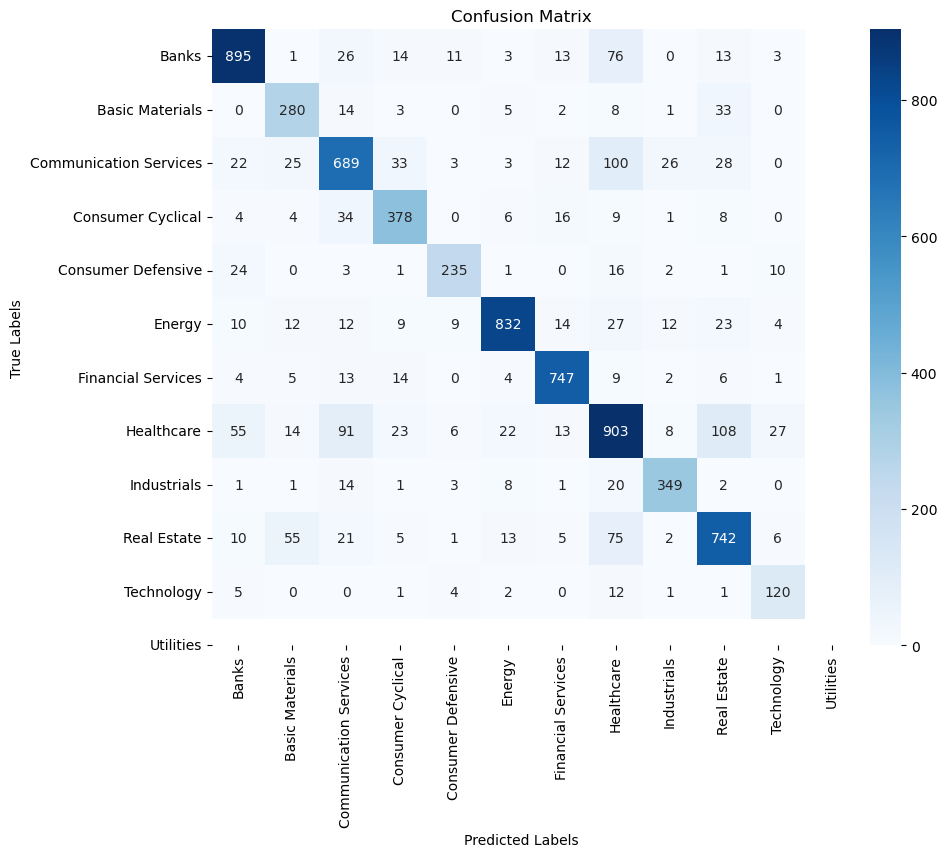

Accuracy: 0.8102
F1 Score: 0.8107


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")



I have used ChatGPT to aid the python syntax 